In [188]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split
import random
import imgaug.augmenters as iaa
import keras
import cv2
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Convolution2D, MaxPooling2D, Dropout, Flatten, Dense

## Importing & Preprocessing data

"driving_log.csv" is the file that contains all the information have like the names of the different images (center, left and right) but also the steering angle, throttle, brake and speed. We use the variable directory to define the path to the file. We give our data columns so it does not mistake the first row as the columns of our data. Using head we show the first 5 values.

In [189]:
dir = "C:\Thomas More 2023-2024\AI\AutonomousDrivingCarTeam5\DeepLearning"
columns = ["center", "left", "right", "steering", "throttle", "brake", "speed"]
data = pd.read_csv(os.path.join(directory, "driving_log.csv"), names=columns)
pd.set_option("display.max_colwidth", None)
data.head()

,center,left,right,steering,throttle,brake,speed
0,C:\Thomas More 2023-2024\AI\AutonomousDrivingCarTeam5\DeepLearning\IMG\center_2023_12_05_15_10_41_148.jpg,C:\Thomas More 2023-2024\AI\AutonomousDrivingCarTeam5\DeepLearning\IMG\left_2023_12_05_15_10_41_148.jpg,C:\Thomas More 2023-2024\AI\AutonomousDrivingCarTeam5\DeepLearning\IMG\right_2023_12_05_15_10_41_148.jpg,0.0,0.0,0.0,0.000079
1,C:\Thomas More 2023-2024\AI\AutonomousDrivingCarTeam5\DeepLearning\IMG\center_2023_12_05_15_10_41_250.jpg,C:\Thomas More 2023-2024\AI\AutonomousDrivingCarTeam5\DeepLearning\IMG\left_2023_12_05_15_10_41_250.jpg,C:\Thomas More 2023-2024\AI\AutonomousDrivingCarTeam5\DeepLearning\IMG\right_2023_12_05_15_10_41_250.jpg,0.0,0.0,0.0,0.000078
2,C:\Thomas More 2023-2024\AI\AutonomousDrivingCarTeam5\DeepLearning\IMG\center_2023_12_05_15_10_41_356.jpg,C:\Thomas More 2023-2024\AI\AutonomousDrivingCarTeam5\DeepLearning\IMG\left_2023_12_05_15_10_41_356.jpg,C:\Thomas More 2023-2024\AI\AutonomousDrivingCarTeam5\DeepLearning\IMG\right_2023_12_05_15_10_41_356.jpg,0.0,0.0,0.0,0.000078
3,C:\Thomas More 2023-2024\AI\AutonomousDrivingCarTeam5\DeepLearning\IMG\center_2023_12_05_15_10_41_458.jpg,C:\Thomas More 2023-2024\AI\AutonomousDrivingCarTeam5\DeepLearning\IMG\left_2023_12_05_15_10_41_458.jpg,C:\Thomas More 2023-2024\AI\AutonomousDrivingCarTeam5\DeepLearning\IMG\right_2023_12_05_15_10_41_458.jpg,0.0,0.0,0.0,0.000078
4,C:\Thomas More 2023-2024\AI\AutonomousDrivingCarTeam5\DeepLearning\IMG\center_2023_12_05_15_10_41_561.jpg,C:\Thomas More 2023-2024\AI\AutonomousDrivingCarTeam5\DeepLearning\IMG\left_2023_12_05_15_10_41_561.jpg,C:\Thomas More 2023-2024\AI\AutonomousDrivingCarTeam5\DeepLearning\IMG\right_2023_12_05_15_10_41_561.jpg,0.0,0.0,0.0,0.000078


We do not want to be using the entire path of our local machine and use os function to split the path into the directory (head) and filename (tail).

In [190]:
def pathleaf(path):
    head, tail = os.path.split(path)
    return tail

data["center"] = data["center"].apply(pathleaf)
data["left"] = data["left"].apply(pathleaf)
data["right"] = data["right"].apply(pathleaf)
data.head()


,center,left,right,steering,throttle,brake,speed
0,center_2023_12_05_15_10_41_148.jpg,left_2023_12_05_15_10_41_148.jpg,right_2023_12_05_15_10_41_148.jpg,0.0,0.0,0.0,0.000079
1,center_2023_12_05_15_10_41_250.jpg,left_2023_12_05_15_10_41_250.jpg,right_2023_12_05_15_10_41_250.jpg,0.0,0.0,0.0,0.000078
2,center_2023_12_05_15_10_41_356.jpg,left_2023_12_05_15_10_41_356.jpg,right_2023_12_05_15_10_41_356.jpg,0.0,0.0,0.0,0.000078
3,center_2023_12_05_15_10_41_458.jpg,left_2023_12_05_15_10_41_458.jpg,right_2023_12_05_15_10_41_458.jpg,0.0,0.0,0.0,0.000078
4,center_2023_12_05_15_10_41_561.jpg,left_2023_12_05_15_10_41_561.jpg,right_2023_12_05_15_10_41_561.jpg,0.0,0.0,0.0,0.000078


We training a model you want to data to be diversified and not have a large amount of a single value because this will make the model biased.
Let's have a look at the steering values of our data.

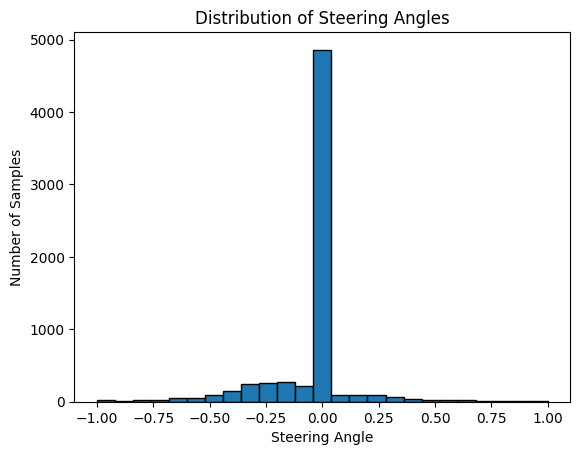

In [191]:
plt.hist(data["steering"], bins=25, edgecolor="black")
plt.xlabel("Steering Angle")
plt.ylabel("Number of Samples")
plt.title("Distribution of Steering Angles")
plt.show()


We see that there are a large amount of 0 samples and so we remove most of them. We also randomly delete 0 values to make sure we don't delete everything but the last 800 steering values.

In [192]:
zero_indices = data[data["steering"] == 0].index

# Randomly select a portion of the zero values to keep
selected_zero_indices = np.random.choice(zero_indices, size=800, replace=False)

# Combine the selected zero indices with the indices of non-zero values
selected_indices = np.concatenate([selected_zero_indices, data[data["steering"] != 0].index])

# Create a new DataFrame with the selected indices
selected_data = data.loc[selected_indices].copy()


Let's see again

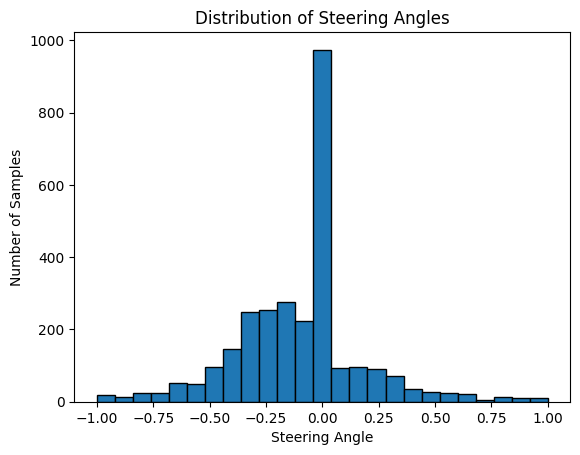

In [193]:
import matplotlib.pyplot as plt
import pandas as pd

plt.hist(selected_data["steering"], bins=25, edgecolor="black")
plt.xlabel("Steering Angle")
plt.ylabel("Number of Samples")
plt.title("Distribution of Steering Angles")
plt.show()

We have 3 different types of images that we use for our dataframe. Center, left and right. The angle or "viewpoint" is different in these images. Because of this we will make a function where we put our images into an array and adjust the steering based on what type of image it is. We have an image path as an empty list and steering as an empty list and use a for loop to go through our entire dataframe.

In [194]:
def load_img_steering(datadir, df):
    image_paths = []
    steerings = []

    for i in range(len(df)):
        center, left, right = df.iloc[i, 0], df.iloc[i, 1], df.iloc[i, 2]
        
        image_paths.extend([
            os.path.join(datadir, center.strip()),
            os.path.join(datadir, left.strip()),
            os.path.join(datadir, right.strip())
        ])
        
        steering = float(df.iloc[i, 3])
        steerings.extend([steering, steering + 0.15, steering - 0.15])

    return np.asarray(image_paths), np.asarray(steerings)


Now we split our data into test and validation set.

In [195]:
image_paths, steerings = load_img_steering( dir + "/IMG", selected_data)
X_train, X_valid, y_train, y_valid = train_test_split(image_paths, steerings, test_size=0.2, random_state=6)

print("Training Samples: {}\nValid Samples: {}".format(len(X_train), len(X_valid)))

Training Samples: 6943
Valid Samples: 1736


Let's show our datasets in a histogram.

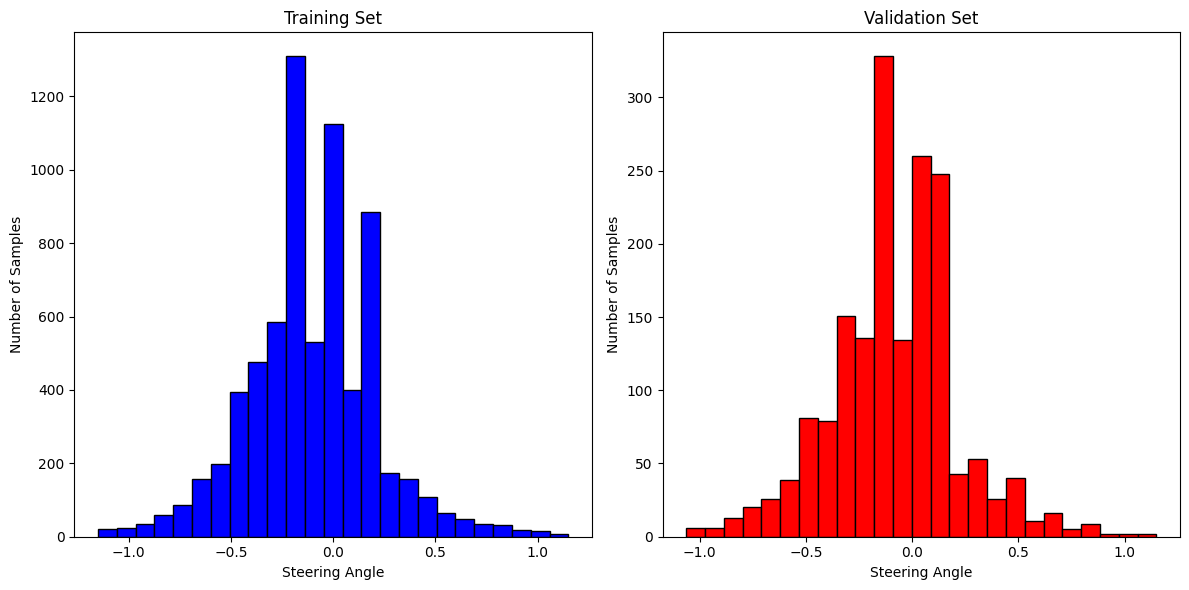

In [196]:
plt.figure(figsize=(12, 6))

# Plot histogram for the training set
plt.subplot(1, 2, 1)
plt.hist(y_train, bins=25, edgecolor="black", color='blue')
plt.xlabel("Steering Angle")
plt.ylabel("Number of Samples")
plt.title("Training Set")

# Plot histogram for the validation set
plt.subplot(1, 2, 2)
plt.hist(y_valid, bins=25, edgecolor="black", color='red')
plt.xlabel("Steering Angle")
plt.ylabel("Number of Samples")
plt.title("Validation Set")

plt.tight_layout() 
plt.show()

Now we will begin preprocessing the images. We will first start by adding a zoom to the image because we only care about the racetrack which is in front of us and not the sky which takes in a large portion of the original image. We can modify our zoom factor to get the result we want but don't make it too high because it could cut away the left or right racetrack line if we zoom in too hard. We choose a random image to visualize the result this way we can test if this amount of zoom isn't too much on all images. We also show the original and modified image next to eachother so you can see the clear change.

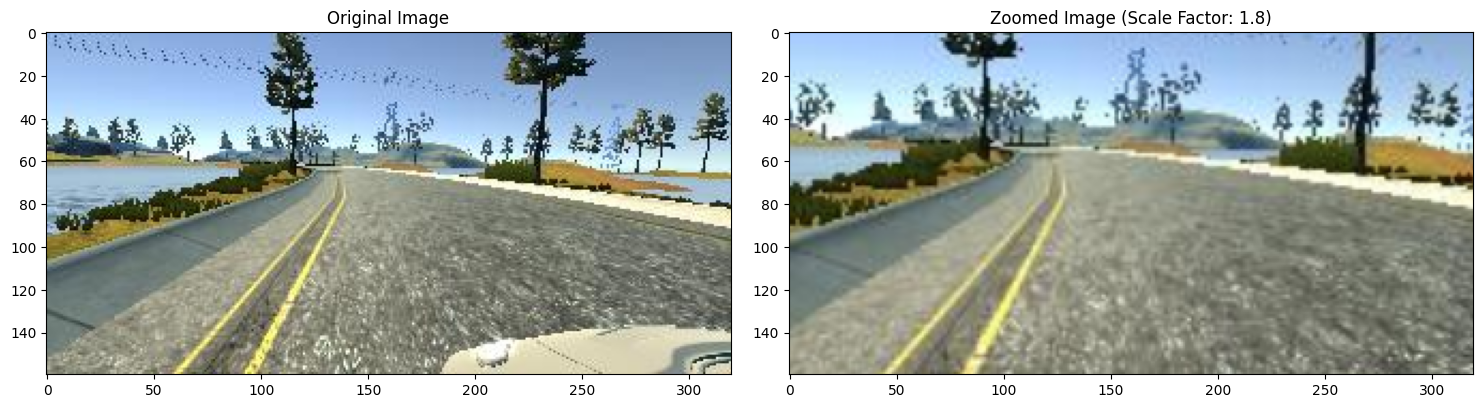

In [197]:
def zoom(image, scale_factor):
    zoom_augmenter = iaa.Affine(scale=(1, scale_factor))
    augmented_image = zoom_augmenter.augment_image(image)
    return augmented_image


image_path = image_paths[random.randint(0, 1000)]
original_image = mpimg.imread(image_path)

zoom_factor = 1.8
zoomed_image = zoom(original_image, zoom_factor)

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()

axs[0].imshow(original_image)
axs[0].set_title("Original Image")

axs[1].imshow(zoomed_image)
axs[1].set_title("Zoomed Image (Scale Factor: {})".format(zoom_factor))

plt.show()

The racetrack that was used to train these images looks quite look an oval. This means that almost all turns will be towards the left and almost none towards the right (except when you oversteer on puprose). To make sure our model isn't biased we randomly flip half of the images which would make a turn towards the left actually become a turn towards the right. We use OpenCV flip function to make this happen.

Our first way of fixing this problem was by driving around the racetrack in the opposite direction but luckily found this easier way of removing this bias of the left turn.

Text(0.5, 1.0, 'Flipped Image - Steering Angle: -0.15')

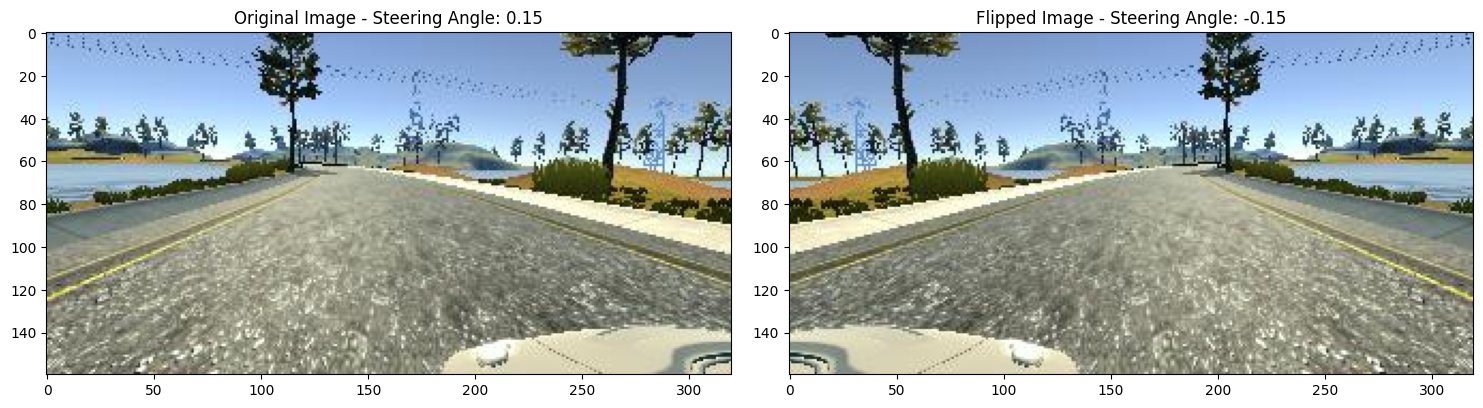

In [198]:
def random_flip(image, steering_angle):
    flipped_image = cv2.flip(image, 1)
    flipped_steering_angle = -steering_angle
    return flipped_image, flipped_steering_angle

random_index = random.randint(0, 1000)
image_path = image_paths[random_index]
steering_angle = steerings[random_index]

original_image = mpimg.imread(image_path)
flipped_image, flipped_steering_angle = random_flip(original_image, steering_angle)

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()

axs[0].imshow(original_image)
axs[0].set_title(f"Original Image - Steering Angle: {steering_angle}")

axs[1].imshow(flipped_image)
axs[1].set_title(f"Flipped Image - Steering Angle: {flipped_steering_angle}")



We also shift the image both in a horizontal and vertical matter.

Text(0.5, 1.0, 'Panned Image')

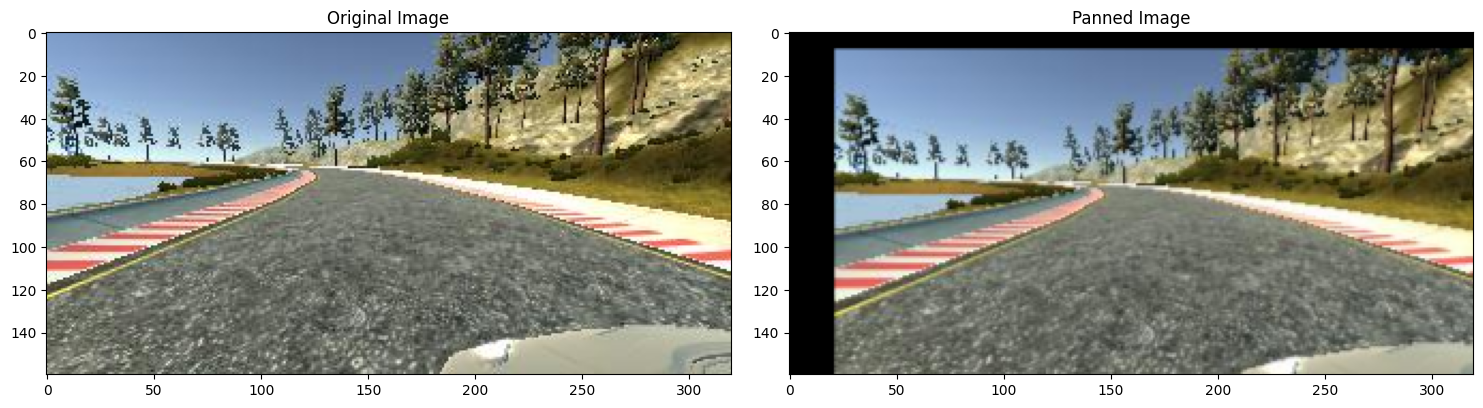

In [199]:
def pan(image):
    pan = iaa.Affine(translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)})
    image = pan.augment_image(image)
    return image


image = image_paths[random.randint(0, 1000)]
original_image = mpimg.imread(image)
panned_image = pan(original_image)

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()

axs[0].imshow(original_image)
axs[0].set_title("Original Image")

axs[1].imshow(panned_image)
axs[1].set_title("Panned Image")

We now still need to apply this flip and zoom on half of our images. We do this with a random_augment function. We will use this later on when we feed the data to our model. We give our preprocessing steps a 50% chance of happening.

In [200]:
def random_augment(image, steering_angle):
    image = mpimg.imread(image)
    if np.random.rand() < 0.5:
        image = pan(image)
    if np.random.rand() < 0.5:
        scale_factor = 1.8 
        image = zoom(image, scale_factor)
    if np.random.rand() < 0.5:
        image, steering_angle = random_flip(image, steering_angle)
    return image, steering_angle


Another preprocessing method we could've used on the images were changing the brightness to change weather conditions. We however did not implement these because they seemed unnecessary in this case. For example the weather is always the same in the Udacity simulator.

We continue with some basic image processing which we also used in our other AI model. 

We start with cropping the images by performing a slicing operation on the numpy array which represents the image. The image is basically made into a 3D array representing the pixel values of our RGB image (height x width x channels). We effectively crop the image vertically keeping only the portion between row 60 and 134. The 2 ":" after that means that we include all collumns and include all color channels.

Next we change the colors of the images to YUV format meaning which to put it simply seperates brightness and color information from eachother. Y = brightness & UV = color information. This will make it easier to extract features more effectively.

We then use a Gaussian Blurring filter to smoothen the image by averaging the pixel value in the neighbourhood of each pixel. The tupel "3,3" specifies the size of the kernel, this determines the extent of the blurring filter. the "0" after that is the standard deviation that will be used. When kept 0 OpenCV calculates it automatically.

We resize the image for easier processing because we have a very large amount of images.

Lastly we normalize the pixel values to make sure that all values are within a uniform range (0 - 1)

In [201]:
def img_preprocess(img):
    ## Crop image to remove unnecessary features
    img = img[60:135, :, :]
    ## Change to YUV image
    img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    ## Gaussian blur
    img = cv2.GaussianBlur(img, (3, 3), 0)
    ## Decrease size for easier processing
    img = cv2.resize(img, (200, 66))
    ## Normalize values
    img = img / 255
    return img

Let's see what these changes did by again showing a random image before and after these changes.

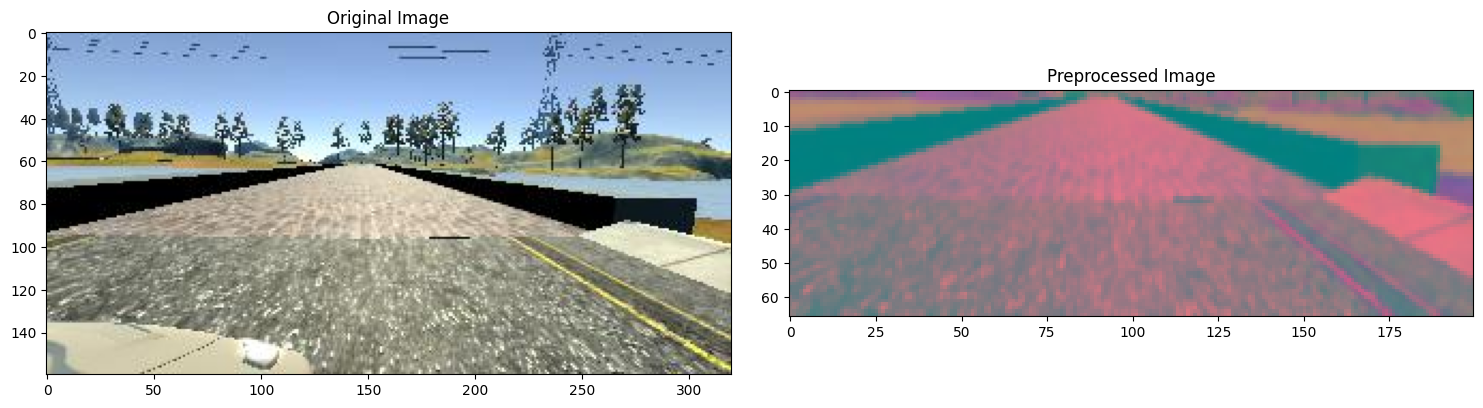

In [202]:
def visualize_original_and_preprocessed(image_paths, index):
    image_path = image_paths[index]
    original_image = mpimg.imread(image_path)
    preprocessed_image = img_preprocess(original_image)

    fig, axs = plt.subplots(1, 2, figsize=(15, 10))
    fig.tight_layout()

    axs[0].imshow(original_image)
    axs[0].set_title("Original Image")

    axs[1].imshow(preprocessed_image)
    axs[1].set_title("Preprocessed Image")

    plt.show()

random_index = random.randint(0, len(image_paths) - 1)
visualize_original_and_preprocessed(image_paths, random_index)


We are finally close to actually training our model. Because of our large amount of data it is not good practice to feed all our data at once. We instead make batches of data which allows us to train the model without loading all data into memory at once. This is called a "generator". If istraining is true it means it's part of the training set and we use the random_augment function. If it is false it means it's part of the validation and we simply load the images without augmentation.

In [203]:
def generate_batch(image_paths, steering_ang, batch_size, istraining):
    while True:
        batch_img, batch_steering = [], []

        for _ in range(batch_size):
            random_index = random.randint(0, len(image_paths) - 1)
            im, steering = random_augment(image_paths[random_index], steering_ang[random_index]) if istraining else (mpimg.imread(image_paths[random_index]), steering_ang[random_index])
            im = img_preprocess(im)

            batch_img.append(im)
            batch_steering.append(steering)

        yield np.asarray(batch_img), np.asarray(batch_steering)


Let's make a single training and validation batch and visualise it.

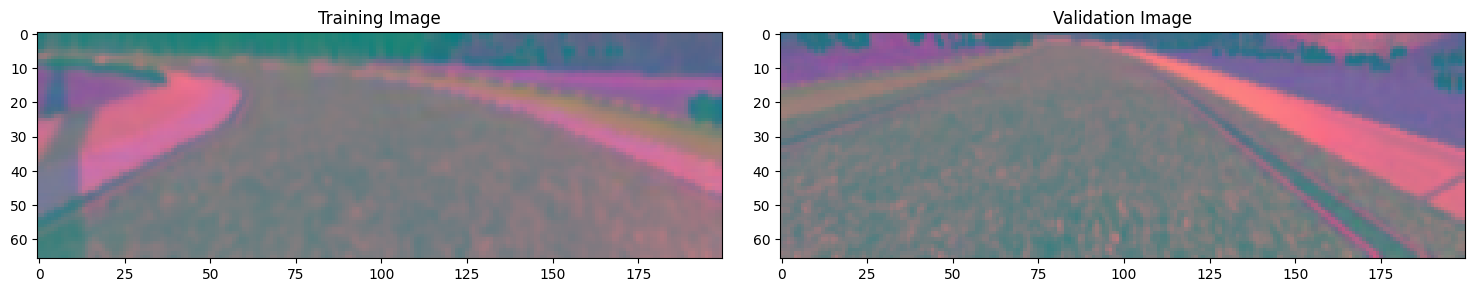

In [204]:
# Create training batch
x_train_gen, y_train_gen = next(generate_batch(X_train, y_train, batch_size=1, istraining=True))

# Generate validation batch
x_valid_gen, y_valid_gen = next(generate_batch(X_valid, y_valid, batch_size=1, istraining=False))

# Plotting
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()

axs[0].imshow(x_train_gen[0])
axs[0].set_title("Training Image")

axs[1].imshow(x_valid_gen[0])
axs[1].set_title("Validation Image")

plt.show()

For the designing of our model architecture I first tried to make some architecture myself but that did not always give the desired result. In the simulator the car did not drive well and so I did some researched and stumbled on NVIDIA's self driving car architecture which worked fantastic and so that is what I used for the final endresult. Here is an image of the used architecture.

![title](https://www.researchgate.net/profile/Mathew-Monfort/publication/301648615/figure/fig4/AS:357938163142666@1462350516717/CNN-architecture-The-network-has-about-27-million-connections-and-250-thousand.png)

For defining the model architecture, we need to define the model object. Normalization state can be skipped as we have already normalized it. We will add the convolution layer. As compared to the model, we will organize accordingly. The Nvdia model uses 24 filters in the layer along with a kernel of size 5,5. We will introduce sub sampling. The function reflects to stride length of the kernel as it processes through an image, we have large images. Horizontal movement with 2 pixels at a time, similarly vertical movement to 2 pixels at a time. As this is the first layer, we have to define input shape of the model too i.e., (66,200,3) and the last function is an activation function that is “elu”.

Revisting the model, we see that our second layer has 36 filters with kernel size (5,5) same subsampling option with stride length of (2,2) and conclude this layer with activation ‘elu’.

According to Nvdia model, it shows we have 3 more layers in the convolutional neural network. With 48 filters, with 64 filters (3,3) kernel 64 filters (3,3) kernel Dimensions have been reduced significantly so for that we will remove subsampling from 4th and 5th layer.

Next we add a flatten layer. We will take the output array from previous convolution neural network to convert it into a one dimensional array so that it can be fed to fully connected layer to follow.

Our last convolution layer outputs an array shape of (1,18) by 64.

We end the architecture of Nvdia model with a dense layer containing a single output node which will output the predicted steering angle for our self driving car. Now we will use model.compile() to compile our architecture as this is a regression type example the metrics that we will be using will be mean squared error and optimize as Adam. We will be using relatively a low learning rate that it can help on accuracy. We will use dropout layer to avoid overfitting the data. Dropout Layer sets the input of random fraction of nodes to “0” during each update. During this, we will generate the training data as it is forced to use a variety of combination of nodes to learn from the same data. We will have to separate the convolution layer from fully connected layer with a factor of 0.5 is added so it converts 50 percent of the input to 0. We Will define the model by calling the nvdia model itself. Now we will have the model training process.To define training parameters, we will use model.fit(), we will import our training data X_Train, training data ->y_train, we have less data on the datasets we will require more epochs to be effective. We will use validation data and then use Batch size.

In [205]:
def NvidiaModel():
  model = Sequential()
  model.add(Convolution2D(24,(5,5),strides=(2,2),input_shape=(66,200,3),activation="elu"))
  model.add(Convolution2D(36,(5,5),strides=(2,2),activation="elu"))
  model.add(Convolution2D(48,(5,5),strides=(2,2),activation="elu")) 
  model.add(Convolution2D(64,(3,3),activation="elu"))   
  model.add(Convolution2D(64,(3,3),activation="elu"))
  model.add(Dropout(0.5))
  model.add(Flatten())
  model.add(Dense(100,activation="elu"))
  model.add(Dropout(0.5))
  model.add(Dense(50,activation="elu"))
  model.add(Dropout(0.5))
  model.add(Dense(10,activation="elu"))
  model.add(Dropout(0.5))
  model.add(Dense(1))
  model.compile(optimizer=Adam(learning_rate=1e-3),loss="mse")
  return model

In [206]:
model = NvidiaModel()
print(model.summary())

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_35 (Conv2D)          (None, 31, 98, 24)        1824      
                                                                 
 conv2d_36 (Conv2D)          (None, 14, 47, 36)        21636     
                                                                 
 conv2d_37 (Conv2D)          (None, 5, 22, 48)         43248     
                                                                 
 conv2d_38 (Conv2D)          (None, 3, 20, 64)         27712     
                                                                 
 conv2d_39 (Conv2D)          (None, 1, 18, 64)         36928     
                                                                 
 dropout_28 (Dropout)        (None, 1, 18, 64)         0         
                                                                 
 flatten_7 (Flatten)         (None, 1152)             

In [207]:
history = model.fit(
    generate_batch(X_train, y_train, 100, 1),
    steps_per_epoch=300,
    epochs=16,
    validation_data=generate_batch(X_valid, y_valid, 100, 0),
    validation_steps=200,
    verbose=1,
    shuffle=1,
)

Epoch 1/16
300/300 [==============================] - 128s 425ms/step - loss: 0.1353 - val_loss: 0.0751
Epoch 2/16
300/300 [==============================] - 123s 410ms/step - loss: 0.0959 - val_loss: 0.0727
Epoch 3/16
300/300 [==============================] - 123s 412ms/step - loss: 0.0893 - val_loss: 0.0638
Epoch 4/16
300/300 [==============================] - 121s 405ms/step - loss: 0.0862 - val_loss: 0.0677
Epoch 5/16
300/300 [==============================] - 120s 401ms/step - loss: 0.0826 - val_loss: 0.0616
Epoch 6/16
300/300 [==============================] - 121s 406ms/step - loss: 0.0809 - val_loss: 0.0604
Epoch 7/16
300/300 [==============================] - 124s 413ms/step - loss: 0.0806 - val_loss: 0.0605
Epoch 8/16
300/300 [==============================] - 108s 362ms/step - loss: 0.0779 - val_loss: 0.0595
Epoch 9/16
300/300 [==============================] - 110s 368ms/step - loss: 0.0776 - val_loss: 0.0622
Epoch 10/16
300/300 [==============================] - 112s 375m

We can have dead relu this is when a node in neural network essentially dies and only feeds a value of zero to nodes which follows it. We will change from relu to elu. Elu function has always a chance to recover and fix it errors means it is in a process of learning and contributing to the model. We will plot the model and then save it accordingly in h5 format for a keras file.

Text(0.5, 0, 'Epoch')

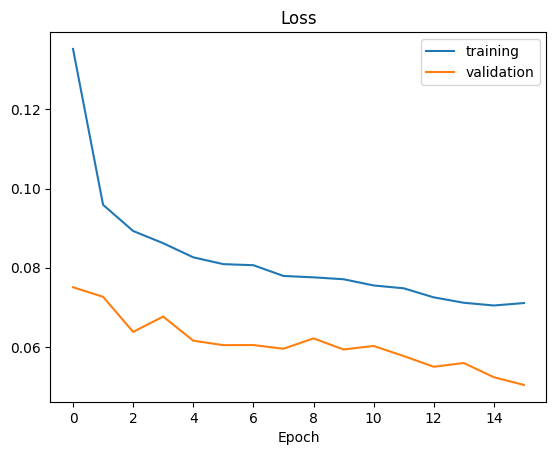

In [208]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.legend(["training", "validation"])
plt.title("Loss")
plt.xlabel("Epoch")

Save model

In [209]:
model.save('model.h5')

c:\Thomas More 2023-2024\AI\AutonomousDrivingCarTeam5\DeepLearning\DLenv\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
